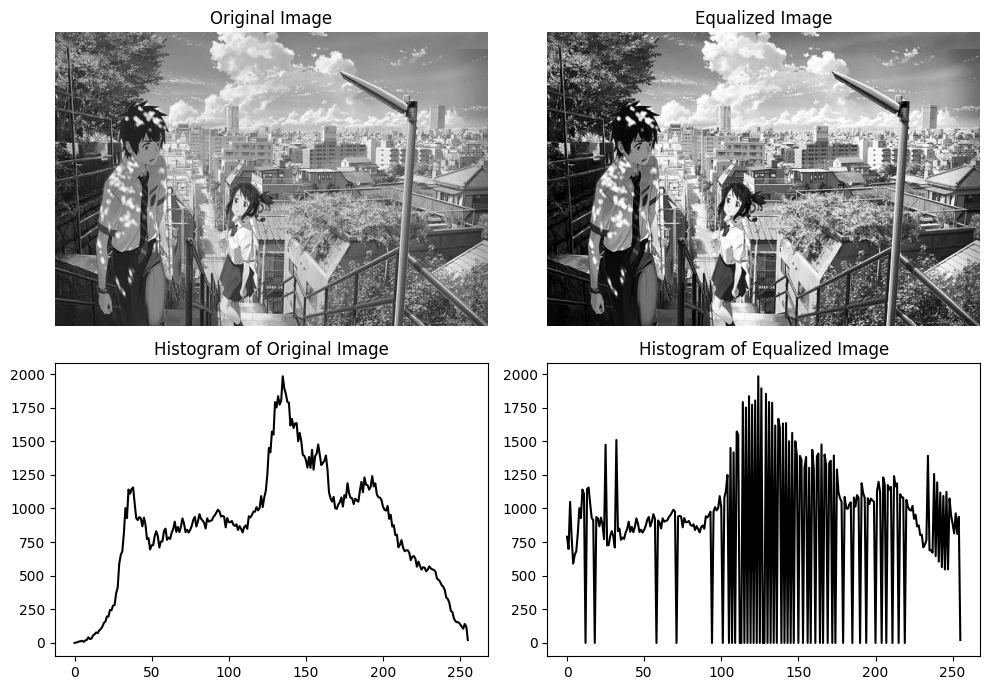

'equalized_histograms.png'

In [13]:
# histogram_equalization
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def calculate_histogram(image):
    histogram, _ = np.histogram(image.flatten(), bins=256, range=[0,256])
    return histogram

def histogram_equalization(image):
    img_np = np.array(image)

    hist = calculate_histogram(img_np)

    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()  

    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf_final = np.ma.filled(cdf_m,0).astype('uint8')

    img_eq = cdf_final[img_np]

    return Image.fromarray(img_eq), cdf_normalized

original_image = Image.open('4.jpg').convert('L')
equalized_image, cdf_normalized = histogram_equalization(original_image)
histogram_original = calculate_histogram(np.array(original_image))
histogram_equalized = calculate_histogram(np.array(equalized_image))

fig, axs = plt.subplots(2, 2, figsize=(10, 7))

axs[0, 0].imshow(original_image, cmap='gray', aspect='auto')
axs[0, 0].axis('off')
axs[0, 0].set_title('Original Image')

axs[1, 0].plot(histogram_original, color='black')
axs[1, 0].set_title('Histogram of Original Image')

axs[0, 1].imshow(equalized_image, cmap='gray', aspect='auto')
axs[0, 1].axis('off')
axs[0, 1].set_title('Equalized Image')

axs[1, 1].plot(histogram_equalized, color='black')
axs[1, 1].set_title('Histogram of Equalized Image')

plt.tight_layout()

output_file = 'equalized_histograms.png'
plt.savefig(output_file)

plt.show()

output_file

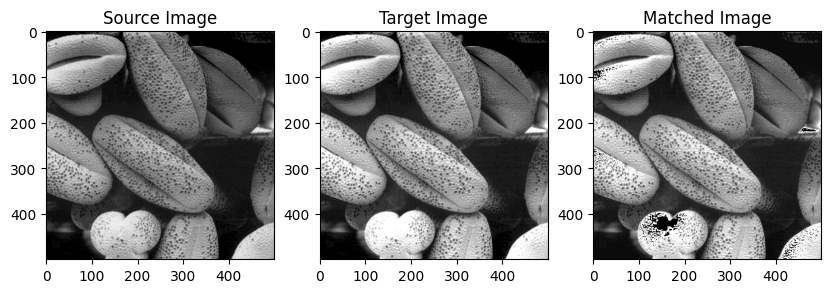

'matched_image.png'

In [15]:
# match_histograms
import numpy as np
import cv2
from matplotlib import pyplot as plt

def calculate_histogram(image):
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    return histogram.flatten()

def calculate_cdf(histogram):
    cdf = histogram.cumsum()
    cdf_normalized = cdf * histogram.max() / cdf.max()  
    return cdf_normalized

def create_lookup(s1, s2):
    lookup = np.zeros(256)
    gj = 0
    for gi in range(256):
        while gj < 256 and s1[gi] > s2[gj]:
            gj += 1
        lookup[gi] = gj
    return lookup

def match_histograms(source_image, target_hist):
    source_hist = calculate_histogram(source_image)
    source_cdf = calculate_cdf(source_hist)
    target_cdf = calculate_cdf(target_hist)

    lookup_table = create_lookup(source_cdf, target_cdf)
    s1, s2 = source_image.shape  
    matched_image = np.zeros_like(source_image)
    
    for i in range(s1):
        for j in range(s2):
            matched_image[i, j] = lookup_table[source_image[i, j]]
    
    return matched_image

source_image = cv2.imread('6.1.tif', cv2.IMREAD_GRAYSCALE)
target_image = cv2.imread('6.2.tif', cv2.IMREAD_GRAYSCALE)


target_hist = calculate_histogram(target_image)


matched_image = match_histograms(source_image, target_hist)


plt.figure(figsize=(10, 5))
plt.subplot(131), plt.imshow(source_image, 'gray'), plt.title('Source Image')
plt.subplot(132), plt.imshow(target_image, 'gray'), plt.title('Target Image')
plt.subplot(133), plt.imshow(matched_image, 'gray'), plt.title('Matched Image')
plt.show()


cv2.imwrite('matched_image.png', matched_image)

matched_image_path = 'matched_image.png'
matched_image_path

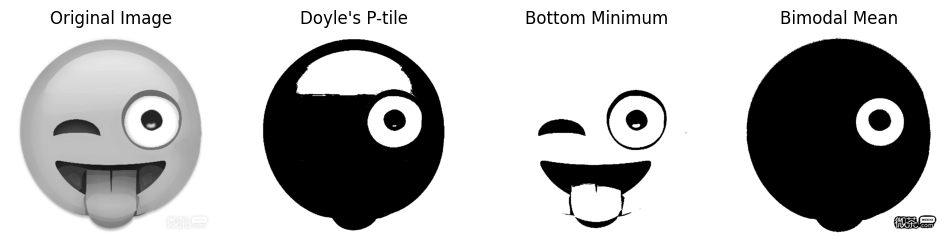

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, argrelmin

def doyles_ptile(image, prior_probability):
    pixels = image.flatten()
    pixels.sort()
    index = int(prior_probability * len(pixels))
    threshold = pixels[index]
    _, thresh_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return thresh_image

def threshold_bottom_minimum(image):
    hist = cv2.calcHist([image], [0], None, [256], [0,256])
    peaks = find_peaks(hist.flatten())[0]
    valleys = argrelmin(hist.flatten())[0]
    if len(peaks) > 1:
        threshold = valleys[np.argmin(np.abs(valleys - np.mean(peaks)))]
    else:
        threshold = np.mean(peaks)
    _, thresh_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return thresh_image

def threshold_bimodal_mean(image):
    hist = cv2.calcHist([image], [0], None, [256], [0,256])
    peaks = find_peaks(hist.flatten())[0]
    if len(peaks) > 1:
        major_peaks = np.sort(peaks)[-2:]
        threshold = np.mean(major_peaks)
    else:
        threshold = np.mean(peaks)
    _, thresh_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return thresh_image

def display_images(images, titles):
    plt.figure(figsize=(12, 4))
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

image = cv2.imread('3.jpg', cv2.IMREAD_GRAYSCALE)

prior_probability = 0.5
doyle_thresh = doyles_ptile(image, prior_probability)
bottom_min_thresh = threshold_bottom_minimum(image)
bimodal_mean_thresh = threshold_bimodal_mean(image)

display_images([image, doyle_thresh, bottom_min_thresh, bimodal_mean_thresh], 
               ["Original Image", "Doyle's P-tile", "Bottom Minimum", "Bimodal Mean"])